In [26]:
import json
import os
import glob as glob
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy import signal
from scipy.signal import find_peaks

class RepMatchedFilter:

    def __init__(self, templates_json_path):
        self.results = {}
        self.openpose_res_folder = '/data0/Results/lifting_openpose/{}/{}'
        self.templates_json_path = templates_json_path
        self.load_templates()
        self.thresholds = {
            'deadlift': 0.7,
            'squat': 0.7,
            'benchpress': 0.7
        }

    def load_templates(self):
        with open(self.templates_json_path, 'r') as file:
            self.templates = json.load(file)
            

    def get_signal(self, keypoint_index, path, lift_type, plot=True):
        list_jsons = sorted(glob.glob('{}/*.json'.format(path)))
        arr = []
        window = []
        cnt = 0
        for jso in list_jsons:
            with open(jso) as f:
                data = json.load(f)
                if data['people']:
                    window.append(data['people'][0]['pose_keypoints_2d'][keypoint_index])
                if cnt % 5 == 0:
                    arr.append(np.mean(window))
                    window = []
            cnt += 1
            
        mean = np.mean(arr)
        std = np.std(arr)

        for i, val in enumerate(arr):
            if (val - mean) / std < -2 or (val - mean) / std > 2:
                if i > 0 and i < len(arr) - 2:
                    arr[i] = (arr[i - 1] + arr[i + 1]) / 2
                elif i == 0:
                    arr[i] = arr[1]
                else:
                    arr[i] = arr[-2]

        
        # Normalize the data.
        if not arr:
            return arr
        
        minimum = min(arr)
        maximum = max(arr)
        
        arr = [(x - minimum) / (maximum - minimum) for x in arr]
        
        if plot:
            self.plot_signal([i * 5 for i in range(len(arr))], arr, lift_type)
        
        return arr

    def get_template_signal(self, lift_type, keypoint_index, plot=False, view=None, reversed=False):
        default_view = {
            'squat': 'right',
            'deadlift': 'front',
            'benchpress': 'right'
        }

        if not view:
            view = default_view[lift_type]
        template = self.templates[lift_type][view]

        template_folder = self.openpose_res_folder.format(template['folder'], template['filename'])

        template_jsons = sorted(glob.glob('{}/*.json'.format(template_folder)))
        tmp = []
        cnt = 0
        for jso in template_jsons[template['start_frame']: template['end_frame']]:
            with open(jso) as f:
                data = json.load(f)
                if cnt % 5 == 0:
                    if data['people']:
                        tmp.append(data['people'][0]['pose_keypoints_2d'][keypoint_index])
                    else:
                        tmp.append(tmp[-1])
                cnt += 1

        mean = np.mean(tmp)
        std = np.std(tmp)

        for i, val in enumerate(tmp):
            if (val - mean) / std < -2:
                if i > 0 and i < len(tmp) - 2:
                    tmp[i] = (tmp[i - 1] + tmp[i + 1]) / 2
                elif i == 0:
                    tmp[i] = tmp[1]
                else:
                    tmp[i] = tmp[-2]

        minimum = min(tmp)
        maximum = max(tmp)
        tmp = [(x - minimum) / (maximum - minimum) for x in tmp]
        if plot:
            self.plot_signal([i * 5 for i in range(len(tmp))], tmp, lift_type)
        if reversed:
            return tmp[::-1]
        return tmp

    def apply_filter(self, lift_type, filename, keypoint_index, use_template=False, plot=True):
        
        if filename in self.results:
            return self.results[filename]

        path = self.openpose_res_folder.format(lift_type, filename)

        kpts = self.get_signal(keypoint_index, path, lift_type, plot=plot)
        
        signal_len = len(glob.glob('{}/*.json'.format(path)))

        if not use_template:
            peaks = signal.find_peaks(kpts, self.thresholds[lift_type], 0.0001)
            peaks = [i * 5 for i in peaks[0]]

            reps = self.get_rep_frames(signal_len, peaks)
            
            self.results[filename] = reps
            return reps
        else:
            tmp_signal = self.get_template_signal(lift_type, 
                keypoint_index, plot, view='back')

            lfi = np.correlate(tmp_signal, kpts, mode='same')
            lfi = lfi * lfi

            peaks = signal.find_peaks(lfi, 0, 0.001)
            peaks = [i * 5 for i in peaks[0]]
            reps = self.get_rep_frames(signal_len, peaks)
            self.results[filename] = reps
            return reps
    

    def get_rep_frames(self, signal_len, peaks):
        if len(peaks) == 1:
            if peaks[0] < signal_len // 2:
                return [{'start': 0, 'mid': int(peaks[0]), 'end': 2* int(peaks[0])}]
            return [{'start': int(peaks[0]) - int(signal_len - peaks[0]), 'mid': int(peaks[0]), 'end': signal_len}]
        
        reps = [{} for i in range(len(peaks))]
                    
        for i in range(len(peaks)):
            reps[i]['mid'] = int(peaks[i])
            if i == len(peaks) - 1:
                start = peaks[i - 1] + (peaks[i] - peaks[i - 1]) // 2
                end = min(signal_len, peaks[i] + (peaks[i] - start))
                reps[i]['start'] = int(start)
                reps[i]['end'] = int(end)
            elif i == 0:
                end = peaks[i] + (peaks[i + 1] - peaks[i]) // 2
                start = max(0, peaks[i] - (end - peaks[i]))
                reps[i]['start'] = int(start)
                reps[i]['end'] = int(end)
            else:        
                reps[i]['start'] = int(peaks[i - 1] + (peaks[i] - peaks[i - 1]) // 2)
                reps[i]['end'] = int(peaks[i] + (peaks[i + 1] - peaks[i]) // 2)
            
        filtered_reps = []
        for rep in reps:
            if rep['end'] - rep['start'] > 40:
                filtered_reps.append(rep)
                
        return filtered_reps
            
    def plot_signal(self, x, y, lt):
        keypoint_name = 'Mid-Hip'
        if lt == 'squat':
            keypoint_name = 'Mid-Hip'
        elif lt == 'deadlift':
            keypoint_name = 'Left Shoulder'
        elif lt == 'benchpress':
            keypoint_name = 'Wrist'
        plt.figure(figsize=(20,12))
        markerline, stemlines, baseline = plt.stem(x, y, '-.')
        plt.title('{} Relative Location vs Frame Number'.format(keypoint_name))
        plt.xlabel('Frame Number')
        plt.ylabel('{} Location'.format(keypoint_name))
        plt.show()



In [27]:
rmf = RepMatchedFilter('./templates.txt')

In [10]:
with open('/home/dennyh/dxf/rep_detection/labeled_reps_w_macro.txt', 'r') as f:
    data = pd.read_csv(f)

    
gt_reps = {}
gt_labels = {}
for i, row in data.iterrows():
    reps = gt_reps.get(row['filename'], [])
    reps.append([row['start_frame'], row['end_frame']])
    gt_reps[row['filename']] = reps
    gt_labels[row['filename']] = row['label']

In [11]:
pred_reps = {}
interest_kpt = {
    'benchpress': 22,
    'deadlift': 4,
    'squat': 4
}
for filename in gt_labels:
    pred_reps[filename] = rmf.apply_filter(gt_labels[filename], filename, interest_kpt[gt_labels[filename]], plot=False)
    

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
counts = {
    'squat': {
        'correct': 0,
        'incorrect': 0
    }, 
    'benchpress': {
        'correct': 0,
        'incorrect': 0
    }, 
    'deadlift': {
        'correct': 0,
        'incorrect': 0
    }
}
e = 40
for filename, reps in pred_reps.items():
    lift_type = gt_labels.get(filename)
    if not lift_type:
        continue
    
    reps_ = [[rep['start'], rep['end']] for rep in reps]
    cnt = 0
    for i, rep in enumerate(gt_reps[filename]):
        if i >= len(reps_):
            counts[lift_type]['incorrect'] += 1
        elif reps_[i - cnt][0] > rep[1]:
            cnt += 1
        elif reps_[i - cnt][0] + e > rep[0] > reps_[i- cnt][0] - e \
        and reps_[i - cnt][1] + e > rep[1] > reps_[i - cnt][1] - e:
            counts[lift_type]['correct'] += 1
        else:
            counts[lift_type]['incorrect'] += 1
    

print(counts)
        
        
    

{'squat': {'correct': 78, 'incorrect': 153}, 'deadlift': {'correct': 14, 'incorrect': 106}, 'benchpress': {'correct': 12, 'incorrect': 130}}


In [44]:
import base64, io
from IPython.display import HTML

def play_video(vid_num):
    vids = {
        '2' : 'https://rugby.banatao.berkeley.edu/static/video_data/videos/squat/36441248_189385255089174_9202051522844688384_n.mp4',
    
        '3' : 'https://rugby.banatao.berkeley.edu/static/video_data/videos/squat/35585614_268385877252000_4562125974187016192_n.mp4',
        '4' : 'https://rugby.banatao.berkeley.edu/static/video_data/videos/squat/36401646_263036204445700_3303080328821735424_n.mp4',
        'deadlift-good' : 'https://rugby.banatao.berkeley.edu/static/video_data/videos/deadlift/36958001_1650138371769595_6052175752667856896_n.mp4', 
        'bench' : 'https://rugby.banatao.berkeley.edu/static/video_data/videos/benchpress/35935762_835868019939525_5036015292484943872_n.mp4'
    }
    return HTML(data='''<video width="640" height="480"alt="test" controls>
                <source src="{}" type="video/mp4" />
             </video>'''.format(vids[vid_num])) 

def print_reps(reps):
    for i, rep in enumerate(reps):
        print('Rep #{}: Start Frame: {}, End Frame {}'.format(i + 1, rep['start'], rep['end']))

 

In [47]:
play_video('3')

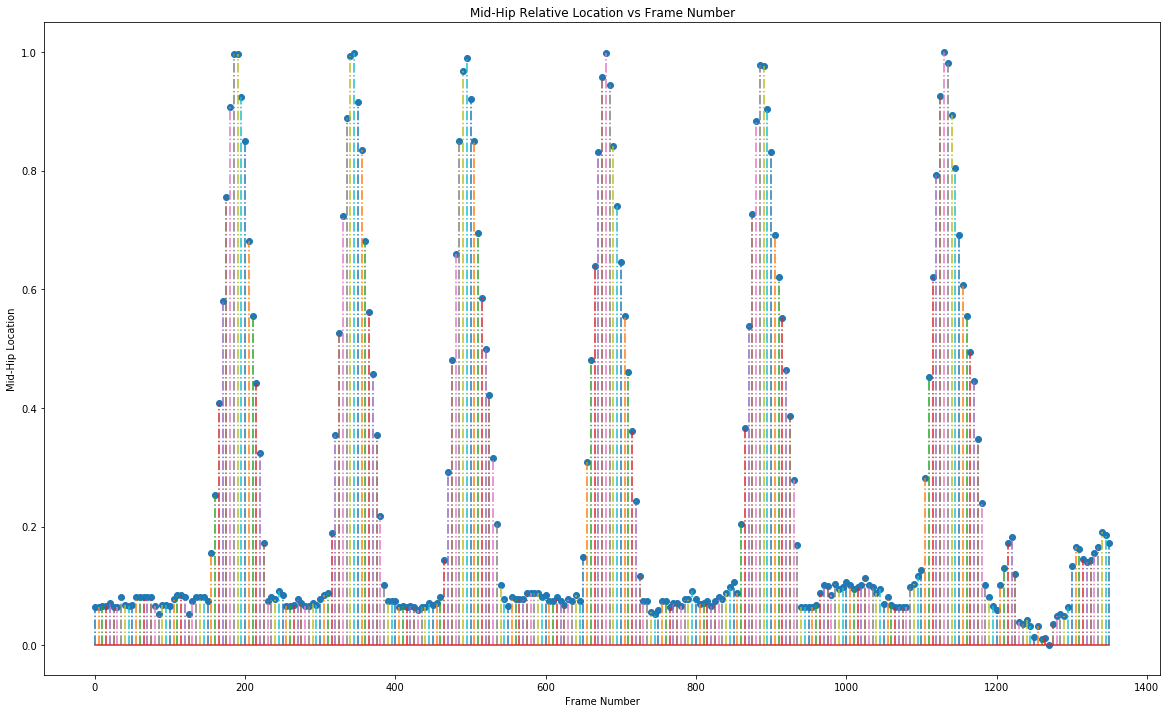

Rep #1: Start Frame: 113, End Frame 267
Rep #2: Start Frame: 267, End Frame 420
Rep #3: Start Frame: 420, End Frame 587
Rep #4: Start Frame: 587, End Frame 782
Rep #5: Start Frame: 782, End Frame 1007
Rep #6: Start Frame: 1007, End Frame 1253


In [46]:
rmf = RepMatchedFilter('./templates.txt')
print_reps(rmf.apply_filter('squat', '35585614_268385877252000_4562125974187016192_n', 25, plot=True))

In [15]:
play_video('2')

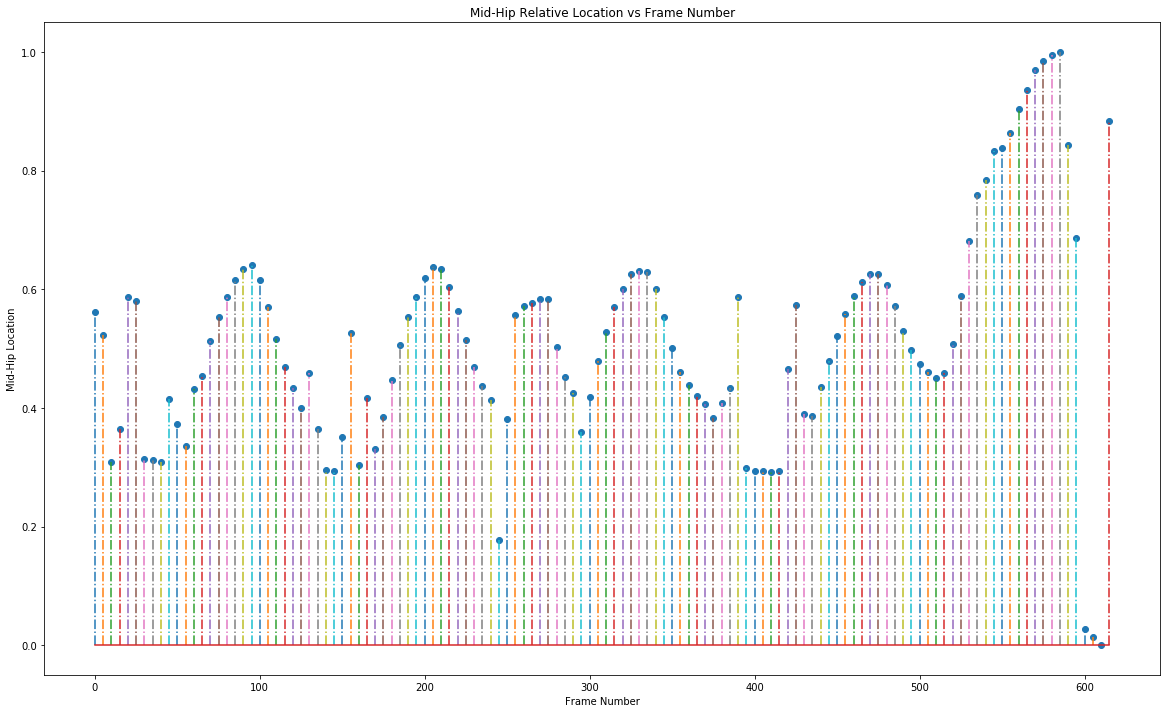

Rep #1: Start Frame: 553, End Frame 617


In [16]:
# Plot for above.
print_reps(rmf.apply_filter('squat', '36441248_189385255089174_9202051522844688384_n', 25, plot=True))

In [19]:
play_video('4')

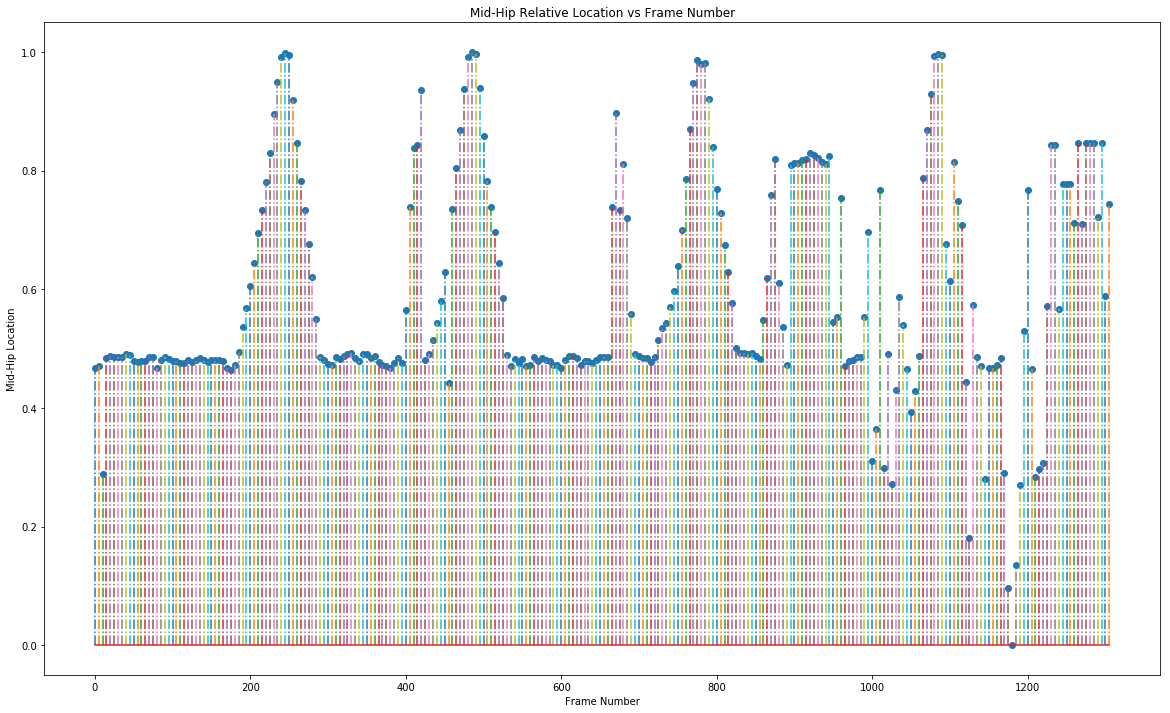

Rep #1: Start Frame: 158, End Frame 332
Rep #2: Start Frame: 332, End Frame 452
Rep #3: Start Frame: 452, End Frame 577
Rep #4: Start Frame: 577, End Frame 675
Rep #5: Start Frame: 675, End Frame 727
Rep #6: Start Frame: 727, End Frame 780
Rep #7: Start Frame: 780, End Frame 830
Rep #8: Start Frame: 830, End Frame 897
Rep #9: Start Frame: 985, End Frame 1047
Rep #10: Start Frame: 1047, End Frame 1095
Rep #11: Start Frame: 1095, End Frame 1152
Rep #12: Start Frame: 1152, End Frame 1222


In [39]:
rmf = RepMatchedFilter('./templates.txt')
print_reps(rmf.apply_filter('squat', '36401646_263036204445700_3303080328821735424_n', 25, plot=True))

In [22]:
play_video('deadlift-good')

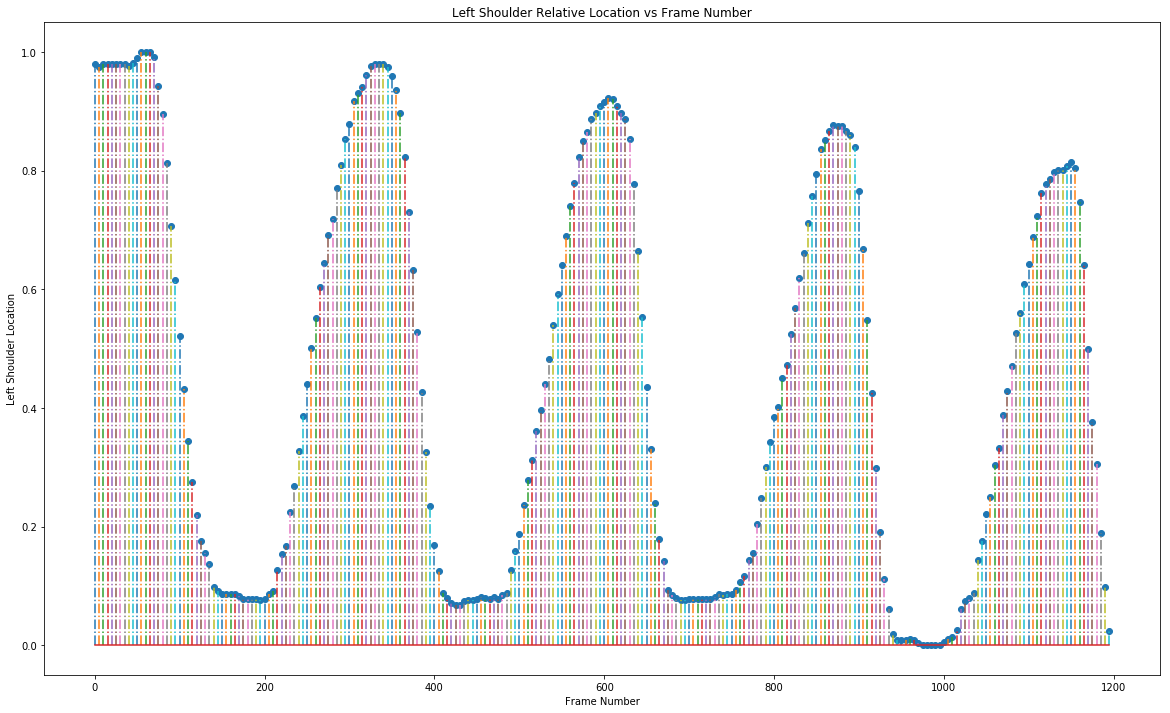

Rep #1: Start Frame: 40, End Frame 335
Rep #2: Start Frame: 335, End Frame 737
Rep #3: Start Frame: 737, End Frame 1010
Rep #4: Start Frame: 1010, End Frame 1197


In [38]:
rmf = RepMatchedFilter('./templates.txt')
print_reps(rmf.apply_filter('deadlift', '36958001_1650138371769595_6052175752667856896_n', 4, plot=True))

In [45]:
play_video('bench')

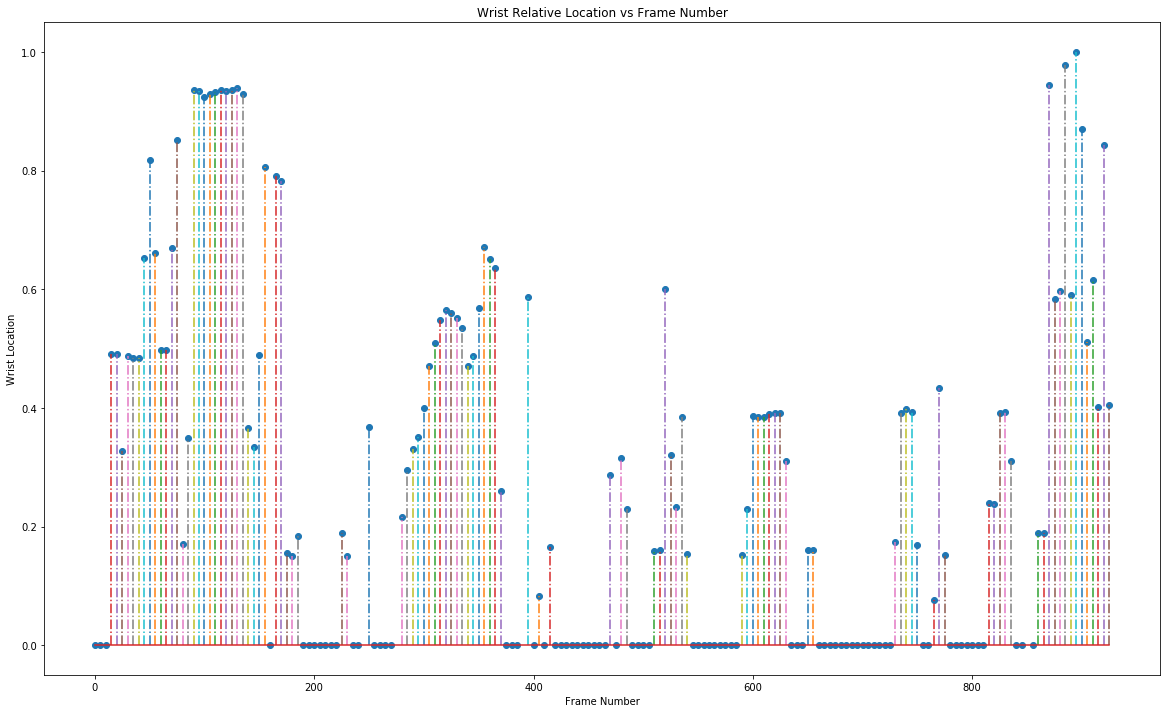

Rep #1: Start Frame: 160, End Frame 517
Rep #2: Start Frame: 517, End Frame 877


In [43]:
rmf = RepMatchedFilter('./templates.txt')
print_reps(rmf.apply_filter('benchpress', '35935762_835868019939525_5036015292484943872_n', 19, plot=True))